# <center>02463 - Active Machine Learning and Agency</center>
## <center>Active machine learning - A gentle introduction</center>

<center>Kristoffer H. Madsen</center>
<br>
<center>
<table style="border:none;border-collapse: collapse;border-style:hidden;background-color:#FFFFFF;border-spacing:0;margin=0;padding:0;cellspacing:0;cellpadding:0">
<tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th  style="text-align:center">Associate Professor</th><th>  </th>
<th style="text-align:center">Senior Researcher</th>
</tr>
        <tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th style="text-align:center">Section for Cognitive Systems</th><th> </th>
<th style="text-align:center">Computational Neuroimaging Group</th>
</tr>
    <tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th style="text-align:center">Department of Applied Mathematics and computer Science</th><th> </th>
<th style="text-align:center">Danish Research Centre for Magnetic Resonance</th>
</tr>
    <tr style="background-color:#FFFFFF">
<th style="text-align:center">Technical University of Denmark</th><th></th>
<th style="text-align:center">Copenhagen University Hospital Hvidovre</th>
</tr>
        <tr style="background-color:#FFFFFF">
<th style="text-align:center">khma@dtu.dk</th><th></th>
<th style="text-align:center">kristofferm@drcmr.dk</th>
</tr>
            <tr style="background-color:#FFFFFF">
<th style="text-align:center"><center><img src=imgs/dtu.png width=70></center></th><th>  </th>
<th style="text-align:center"><center><img src=imgs/drcmr.png width=210></center></th>
</tr>
</table>
    </center>

# Bayesian optimization recap
- Used to find global optimum of a function which is expensive to evaluate 
- Gaussian Processes (GPs) are useful for non-parametric fitting
- GPs can be used to quantify uncertainty of our functions
- Acquisition functions are used to evaluate the "value" of acquiring the objective function value at a new position
- In each step of Bayesian optimization:
    - Update model with new points including kernel hyper-parameters
    - Find optimum of acquisition function in input space
    - Evaluate objective function at point

# Active learning (AL) and relation to Bayesian optimization (BO)
- In BO the objective was to optimize the value of a function
- Natural trade-off between exploitation and exploration
- In AL we seek to maximally reduce the "uncertainty" of our learning scheme
- Hence, you can in a simplistic way think of AL as BO where we are mainly concerned with exploration
    - Here we do not care about how high the value of the function is, we just want to know it with as high precision as possible 

# Ingredients

<img src="imgs/active_learn.png" width=500>

- Teacher / oracle (can give labels)
- Learner (selects which labels to obtain)
    - Uncertainty quantification
    - Again knowing how uncertain we are about the labels of data points (where we do not know the label) is key

# Learning scenarios
- Pool-based sampling
    - A collection/pool of unlabeled data is available, the learner gets to select from this pool
- Stream-based selective sampling
    - Samples are presented sequentially the learner gets to choose whether to query the label for each of these
- Membership query synthesis
    - The learner can request a label for any point in the input set
    - Can be considered a special case of pool-based sampling where all data points are available in the pool

<img src=imgs/pool_based_sampling.png>

<img src=imgs/stream_based_selective_sampling.png>

<img src=imgs/membership_query_synthesis.png>

# A simple example
- Imagine a setting where you seek to classify digits (MNIST)
- We desire to train out favorite model, but that requires (a lot of) labelled data
- It is very tedious to label all examples, can we somehow do well without doing so?
- Quite obvious that some samples are more informative than others 
- Simple example: If we only labeled very few 2's (but a substantial amount of examples of other numbers) the model will be very uncertain about these
- Then it is likely a good idea to sample more 2's, while holding a bit back on the others
- There is really no reason to produce label where we (more or less) already know the answer 

# Classifying digits - pool based example
- We have the entire MNIST dataset but no labels
1. Manually label a few samples
2. Train supervised classification model on these samples
3. From the model (or other "magic" which we will get back to) obtain an estimate of how uncertain the model is on each of the remaining samples
4. Label the most uncertain sample
5. Repeat steps 2-4 until we get too tired to label more samples


# What to sample?
- Somehow we need to assess what we are uncertain about
    - Uncertainty sampling (get the data we are most uncertain about)
- What observation would have largest impact on our current belief/model/generalization error
    - Expected impact
- Reduce variance of prediction or model parameters

# Quantify uncertainty
- In Bayesian optimization we could calculate the variance of each point in the input space conditioned on the current observations
- A simple scheme could be to simply sample the point with the largest variance
- Below and example in GP regression the objective is to learn the function
- The green line indicates a scaled variance

<IPython.core.display.Javascript object>


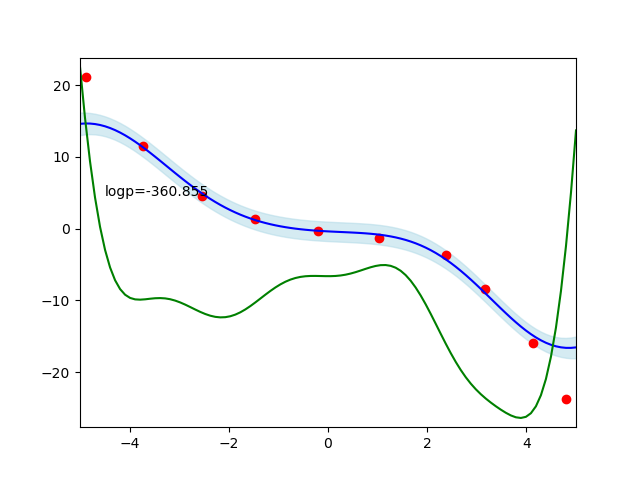

In [14]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure('GP regression');
ax = fig.add_subplot(111);

In [15]:

global step
step = 0
import torch as t
c=(np.random.rand(5)-0.5)*2

def func(x):
    y=c[0]*np.sin(x+c[1]*2*np.pi)+c[2]*x+c[3]/3*x**2+c[4]/6*x**3
    return y+0.3*np.random.randn(*y.shape)

yrange=(np.min(func(np.linspace(-5,5,100)))-1,1+np.max(func(np.linspace(-5,5,100))))

## kernel definition
def squared_exponential_kernel(a, b, lengthscale, variance):
    """ GP squared exponential kernel """
    # compute the pairwise distance between all the point
    # sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqdist = (a**2).sum(1)[:,None] + (b**2).sum(1) - 2 * a@b.transpose(1,0)
    return variance * np.e**(-.5 * (1/lengthscale**2) * sqdist)
    # return variance * np.exp(-.5 * (1/lengthscale**2) * sqdist)

def fit_GP(X, y, Xtest, kernel, lengthscale, kernel_variance, noise_variance, period=1):
    ## we should standardize the data
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)
    K = kernel(X, X, lengthscale, kernel_variance)
    L = np.linalg.cholesky(K + noise_variance * np.eye(len(X)))

    # compute the mean at our test points.
    Ks = kernel(X, Xtest, lengthscale, kernel_variance)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))  #
    mu = Ks.T @ alpha

    v = np.linalg.solve(L, Ks)
    # compute the variance at our test points.
    Kss = kernel(Xtest, Xtest, lengthscale, kernel_variance)
    # s2 = np.diag(K_) - np.sum(Lk ** 2, axis=0)
    covariance = Kss - (v.T @ v)
    # s = np.sqrt(s2)
    return mu, covariance

def loglike(X,y,kernel,lengthscale, kernel_variance, noise_variance):
    #this is not a recommended way of calculating the likelihood from an efficiency point of view
    X = t.from_numpy(np.array(X).reshape(-1, 1))
    y = t.from_numpy(np.array(y).reshape(-1, 1))
    K = kernel(X, X, lengthscale, kernel_variance) + noise_variance * t.eye(len(X),dtype=t.float64)
    return -.5 * y.transpose(1,0)@t.inverse(K)@y - 0.5*t.logdet(K)- .5 * len(X) * np.log(2*np.pi)
    #the below would be better from a stability point of view
    #but the autograd for cholesky seems to be broken at least in pytorch 1.6 
    #L = t.cholesky(K)
    #alpha = t.cholesky_solve(t.cholesky_solve(y,L),L.transpose(1,0))
    #return -.5 * y.transpose(1,0)@alpha - .5 * t.sum(t.diag(L)) - .5 * len(X) * np.log(2*np.pi)

global lengthscale, kernel_variance, noise_var
## parameters definition
lengthscale = 1 # determines the lengths of the wiggle
kernel_variance = 1 # scale factor
noise_var = .2
n_test_point = 100
n_samples = 10
Xtrain = []
ytrain = []

Xtest = np.linspace(-5, 5, n_test_point).reshape(-1,1)

def on_sample(event):
    if event.key=='c':
        global step
        ## we want the mean + the std deviation but also some samples from the posterior
        # clear frame
        plt.clf()
        # we have to refit the GP
        mu, covariance = fit_GP(Xtrain, ytrain, Xtest, squared_exponential_kernel, lengthscale, kernel_variance, noise_var)
        # we should get the var
        var = np.sqrt(np.diag(covariance))
        # and we have to sample for it
        samples = np.random.multivariate_normal(mu.reshape(-1), covariance, n_samples)  # SxM
        plt.plot(Xtrain, ytrain, 'ro')
        plt.gca().fill_between(Xtest.flat, mu - 2 * var, mu + 2 * var, color='lightblue', alpha=0.5)
        plt.plot(Xtest, mu, 'red')
        for sample_id in range(n_samples):
            plt.plot(Xtest, samples[sample_id])
        plt.axis([-5, 5, -5, 5])
        plt.draw()  # redraw
    elif event.key=='o':
        optim_hp()

def on_click1(event):
    global lengthscale, kernel_variance, noise_var
    if not event.xdata is None and not event.ydata is None:
        global step
        Xtrain.append(event.xdata)
        #ytrain.append(event.ydata)
        ytrain.append(func(event.xdata))
        step += 1
        # we have to refit the GP
        redraw()

def redraw():
    global lengthscale, kernel_variance, noise_var
    mu, covariance = fit_GP(Xtrain, ytrain, Xtest, squared_exponential_kernel, lengthscale, kernel_variance, noise_var)
    var = np.sqrt(np.diag(covariance))
    plt.clf()
    plt.plot(Xtrain, ytrain, 'ro')
    plt.gca().fill_between(Xtest.flat, mu - 3 * var, mu + 3 * var,  color='lightblue', alpha=0.5)
    plt.plot(Xtest, mu, 'blue')
    plt.axis([-5, 5, yrange[0], yrange[1]])
    varp=var**2
    varp*=(yrange[1]-yrange[0])*0.95/(varp.max()-varp.min()+np.spacing(1e4))
    varp-=varp.min()-yrange[0]-0.025*(yrange[1]-yrange[0])
    
    plt.plot(Xtest,varp,'green')
    if len(Xtrain)>0:
        plt.text(-4.5,4.5,'logp=%.3f'%loglike(Xtrain,ytrain,squared_exponential_kernel,lengthscale, kernel_variance, noise_var))
    plt.draw() #redraw

def optim_hp():
    global lengthscale, kernel_variance, noise_var
    kpar = [t.autograd.Variable(t.tensor(i,dtype=t.float64),requires_grad=True) for i in (lengthscale, kernel_variance, noise_var)]
    opt = t.optim.LBFGS(kpar,lr=0.1,line_search_fn='strong_wolfe')
    print(loglike(Xtrain,ytrain,squared_exponential_kernel,lengthscale, kernel_variance, noise_var))
    def closure():
        loss = -loglike(Xtrain,ytrain,squared_exponential_kernel,t.abs(kpar[0]),t.abs(kpar[1]),t.abs(kpar[2]))
        opt.zero_grad()
        loss.backward()
        return loss
    for i in range(10):
        opt.step(closure)
    lengthscale = np.abs(kpar[0].item())
    kernel_variance = np.abs(kpar[1].item())
    noise_var = np.abs(kpar[2].item())+np.spacing(1)
    print(loglike(Xtrain,ytrain,squared_exponential_kernel,lengthscale, kernel_variance, noise_var))
    print((lengthscale, kernel_variance, noise_var))
    #redraw()
    widg1.children[0].value=kernel_variance
    widg2.children[0].value=lengthscale
    widg3.children[0].value=noise_var
        
mu, covariance = fit_GP(Xtrain, ytrain, Xtest, squared_exponential_kernel, lengthscale, kernel_variance, noise_var)
var = np.sqrt(np.diag(covariance))
plt.plot(Xtrain, ytrain, 'ro');
plt.gca().fill_between(Xtest.flat, mu - 2 * var, mu + 2 * var,  color='lightblue', alpha=0.5);
plt.plot(Xtest, mu, 'blue')
plt.axis([-5, 5, -5, 5])
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
from IPython.display import display
sliders=[FloatSlider(value=1.,min=0.0, max=10., step=.05,continuous_update=False) for i in range(3)]
sliders[2].value=0.1

def update1(sigma):
    global lengthscale, kernel_variance, noise_var
    kernel_variance=sigma
    redraw()
    
def update2(l):
    global lengthscale, kernel_variance, noise_var
    lengthscale=l
    redraw()
    
def update3(sigma_n):
    global lengthscale, kernel_variance, noise_var
    noise_var=sigma_n
    redraw()
    
widg1=interactive(update1,sigma=sliders[0])
widg2=interactive(update2,l=sliders[1])
widg3=interactive(update3,sigma_n=sliders[2])
fig.canvas.mpl_connect('button_press_event',on_click1)
fig.canvas.mpl_connect('key_press_event',on_sample)
display(widg1)
display(widg2)
display(widg3)


# import numpy as np
# import matplotlib.pyplot as plt
# from ipywidgets import interact
# def kernel_se(x,sigma=1,l=1,sigma_n=0):
#     return sigma**2 * np.exp(-0.5*(x[None]-x[:,None])**2/(l**2)) + sigma_n * np.identity(x.shape[0])
# x=np.arange(40)+1
# K=kernel_se(x)
# plt.figure('Squared exponential Kernel');
# im=plt.imshow(K,cmap='viridis',origin='upper',extent=[x[0],x[-1],x[-1],x[0]]);
# cbar=plt.colorbar()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='sigma', max=10.0, step=0.05…

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='l', max=10.0, step=0.05), O…

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='sigma_n', max=10.0, step=0.…

# Summary
- Active learning seeks to optimize learning by selecting to label the most informative samples
- The algorithm (learner) asks the oracle (which may be noisy) to provide labels for selected samples
- We consider 3 different settings:
    - Pool-based sampling
    - Stream-based selective sampling
    - Membership query synthesis
- Quantification of uncertainty is again key (even more than for optimization)